# Introduction

Ce notebook a pour objectif de rechercher le meilleur modèle de prédiction pour des données déjà traitées. Un des points importants qu'ilm conviendra de résoudre est le déséquilibre entre les classes. Pöur résoudre ce problème, plusieurs possibilités s'offrent à nous. Il conviendra de tester différentes méthodes mais également de tester des combinaisons de méthodes.

 Méthodes de gestion du déséquilibre de classe et un exemple :
     
     - choix de métriques adaptées (Score Fbeta)
     
     - pondération des erreurs en fonction du déséquilibre des classes (class_weight)
     
     - choix d'algorithmes adaptés (Random forest)
     
     - Sous ou sur échantillonnage (SMOTE)

Choix des métriques adaptées :
Dans le cas de classes déséquilibrées, il est fréquent que toutes les erreurs ne se valent pas. Ici, les évènements positifs (défaut de paiement) son bien plus rares que les évènements négatifs. D'un point de vue purement rentable, il vaut mieux faire l'erreur de ne pas octroyer de prêt à un bon payeur que d'en octroyer un à un mauvais payeur. Avoir des faux positifs est donc plus désirable que d'avoir des faux négatifs.

La question est plus complexe s'il on intègre des notions d'éthique, puisque refuser un prêt à un bon payeur à des conséquences négatives, ainsi il faudrait discuter des problématiques éthiques à refuser l'ocrtoi d'un prêt à un bon payeur ou en octroyer un à un mauvais payeur. Il faudrait ensuite calculer un coefficient de non-désirabilité qui permettrait d'évaluer quelle est l'importance des faux positifs par rapport aux faux négatifs.

C'est une question complexe qui demande une réflexion éthique et économique.

Pour l'exercice, nous fixerons le rapport de non désirabilité à cette règle : un faux négatif a un impact négatif 10 fois plus important qu'un faux positif.

A partir de cette règle on peut déterminer le paramètre beta d'un F-beta score qui permettra d'adapter la métrique d'évaluation au problème de déséquilibre des classes et de la différence d'impact des erreurs. Dans ce cas, c'est le recall qui aura plus d'importance que la precision. beta = racine_carrée(10)

Pondération  des erreurs :
La méthode de pondération des erreurs en fonction du déséquilibre des classes consiste à considérer les erreurs effectuées sur la classe mineure comme plus importantes que celles commises sur la classe majeure. Le ratio qui relie ces importances peut correspondre au ratio du nombre d'observations entre la classe mineure et la classe majeure.

Il me semble que cette méthode est redondante avec le choix d'un F-beta score bien que le F-beta soit conçu pour refléter la gravité d'une erreur plutôt qu'une autre alors que le class_weight est conçu pour s'adapter au déséquilibre dans le nombre d'observations. On testera son effet pour le vérifier.

# Stratégie 

En utilisant une métrique F-beta score pondérée pour donner plus d'importance aux faux négatifs (qui sont des erreurs plus importantes), on va rechercher les meilleurs hyper paramètres sur 4 types d'algorithmes différents en utilisant la recherche par grille avec validation croisée et en utilisant le jeu de données sous-échantillonnée pour accélérer les calculs. 

Ensuite, une fois les hyper paramètres trouvés, on testera les 3 jeux de données avec chaque algorithme et on consultera la courbe ROC pour d'éventuelles optimisations du seuil. Une fois le modèle optimal choisi, on testera l'impact du class_weight. On terminera par une synthèse des modèles pour chaque jeu de données.

In [135]:
pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in g:\softwares\anaconda3\lib\site-packages (0.8.1)
Note: you may need to restart the kernel to use updated packages.


In [136]:
import os, sys
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Affichage de toutes les colonnes et lignes lorsque demandé
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [148]:
# Import du fichier de données pré-traitées
default_dir = "G:/OCDataScientist/Projet7"
data = pd.read_csv(os.path.join(default_dir,'data_train.csv'))
SK_ID_CURR = data.pop('SK_ID_CURR')

# Création d'un imputer pour remplacer les valeurs manquantes
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# Remplacement des valeurs manquantes
temp_DF = pd.DataFrame(imputer.fit_transform(data))
# Réintégration des colonnes et index
temp_DF.columns = data.columns
temp_DF.index = data.index
data = temp_DF

# Création d'un scaler 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(data)

# Normalisation des variables
temp_DF = pd.DataFrame(scaler.transform(data))
# Réintégration des colonnes et index
temp_DF.columns = data.columns
temp_DF.index = data.index
data = temp_DF

# Sauvegarde du DataFrame des données prêtes à être modélisées
#Export des fichiers de données traités
output_dir = "G:/OCDataScientist/Projet7"
data.to_csv(os.path.join(output_dir,'data_train_std.csv'), index=False)

# Décomposition train/test
y = data['TARGET'].values
X = data.drop(columns = ['TARGET']).values
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,
                                                                    random_state=0)

In [5]:
data.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Cult

In [6]:
# Affichage des classes avec t-sne
from sklearn import manifold
pca = manifold.TSNE(n_components=2, perplexity=30, n_iter=5000, init='pca')
# Sous échantillonnage pour réduire les temps de calcul
data_sample = data.sample(n=5000)
y_sample = data_sample['TARGET'].values
X_sample = data_sample.drop(columns = ['TARGET']).values

X_pca = pca.fit_transform(X_sample)

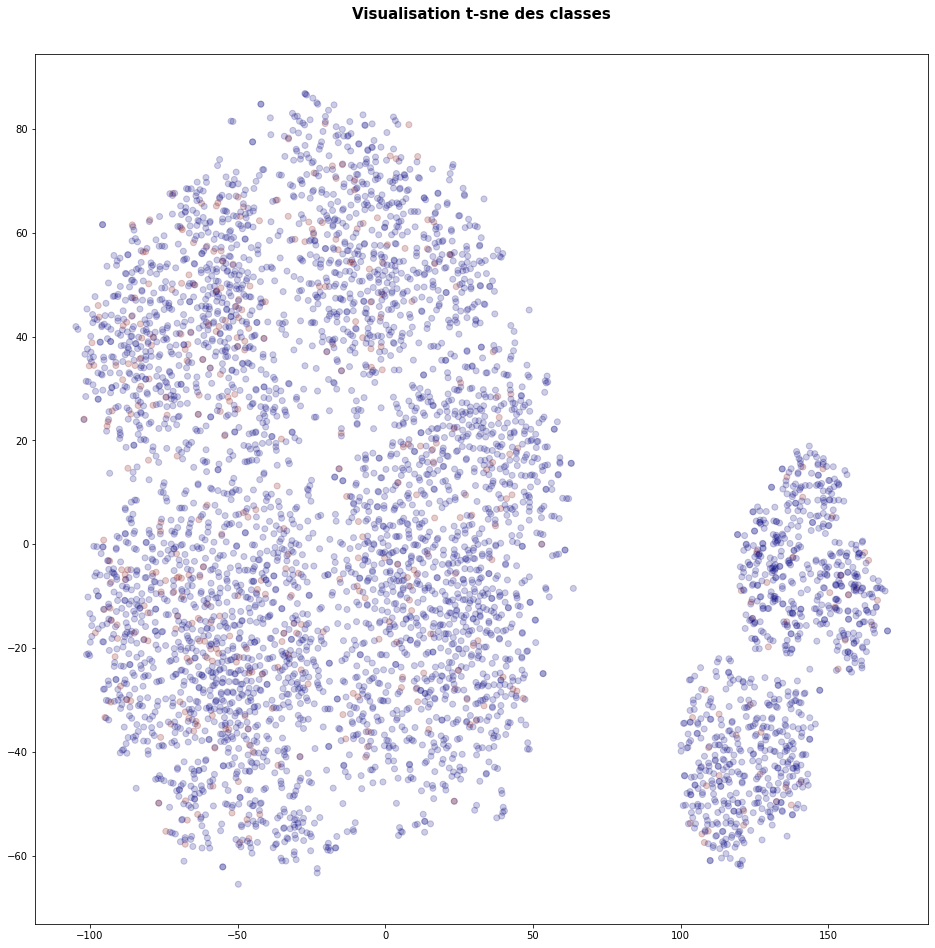

In [7]:
# Graphique de visualisation des classes selon deux composantes t-sne
plt.figure(figsize=(16,16))
plt.scatter(X_pca[:,0],X_pca[:,1],c=y_sample.astype(np.float), cmap = 'jet', alpha=.2)
plt.title('Visualisation t-sne des classes', fontsize = 15, pad = 35, fontweight = 'bold')

plt.show()

Si des clusters se démarquent, ils ne correspondent pas aux classes. Il semble qu'une classification efficace sera très compliquée à mettre en oeuvre.

In [8]:
# Sous-échantillonnage
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, replacement=True)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Vérification
from collections import Counter
print('Répartition originale:', Counter(y_train))
print('Répartition après sous-échantillonnage', Counter(y_train_rus))

Répartition originale: Counter({0.0: 197772, 1.0: 17485})
Répartition après sous-échantillonnage Counter({0.0: 17485, 1.0: 17485})


In [9]:
# Sur-échantillonnage SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Vérification
from collections import Counter
print('Répartition originale:', Counter(y_train))
print('Répartition après sur-échantillonnage', Counter(y_train_smote))

Répartition originale: Counter({0.0: 197772, 1.0: 17485})
Répartition après sur-échantillonnage Counter({0.0: 197772, 1.0: 197772})


In [10]:
# Création d'une métrique adaptée Fbeta score pour le GridSearchCV
from sklearn import metrics
target = metrics.make_scorer(metrics.fbeta_score, beta=3.16)

Training Time: 0.07
Testing Time: 525.71
Accuracy: 0.915
Fbeta: 0.018
[[84290   624]
 [ 7220   120]]
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     84914
         1.0       0.16      0.02      0.03      7340

    accuracy                           0.91     92254
   macro avg       0.54      0.50      0.49     92254
weighted avg       0.86      0.91      0.88     92254



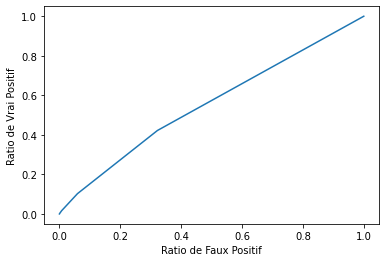

Training Time: 0.01
Testing Time: 75.26
Accuracy: 0.551
Fbeta: 0.411
[[46450 38464]
 [ 3000  4340]]
              precision    recall  f1-score   support

         0.0       0.94      0.55      0.69     84914
         1.0       0.10      0.59      0.17      7340

    accuracy                           0.55     92254
   macro avg       0.52      0.57      0.43     92254
weighted avg       0.87      0.55      0.65     92254



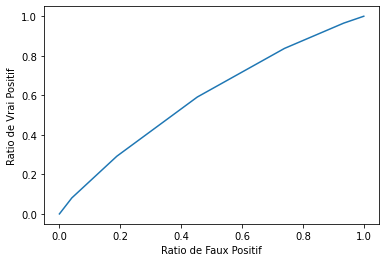

Training Time: 0.14
Testing Time: 1048.88
Accuracy: 0.631
Fbeta: 0.345
[[54863 30051]
 [ 3993  3347]]
              precision    recall  f1-score   support

         0.0       0.93      0.65      0.76     84914
         1.0       0.10      0.46      0.16      7340

    accuracy                           0.63     92254
   macro avg       0.52      0.55      0.46     92254
weighted avg       0.87      0.63      0.72     92254



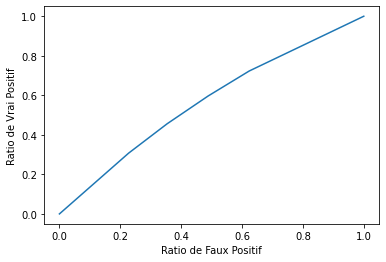

In [10]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
# Pour le modèle KNN, les paramètres par défauts conviendront.

# Entrainement sur le jeu de données déséquilibré
knn_imb = KNeighborsClassifier(n_jobs = -1)
start = time()
knn_imb.fit(X_train, y_train)
end = time()
time_knn_imb_train = end - start
print("Training Time: {:.2f}".format(time_knn_imb_train))
# Prédiction
start = time()
y_knn_imb_pred = knn_imb.predict(X_test)
end = time()
time_knn_imb_pred = end - start
print("Testing Time: {:.2f}".format(time_knn_imb_pred))
# Métriques
acc_knn_imb = metrics.accuracy_score(y_test, y_knn_imb_pred)
print("Accuracy: {:.3f}".format(acc_knn_imb))
fbeta_knn_imb = metrics.fbeta_score(y_test, y_knn_imb_pred, beta=3.16)
print("Fbeta: {:.3f}".format(fbeta_knn_imb))
confusion_knn_imb = metrics.confusion_matrix(y_test, y_knn_imb_pred)
print(confusion_knn_imb)
print(metrics.classification_report(y_test, y_knn_imb_pred))
# Courbe ROC
fpr, tpr, _ = metrics.roc_curve(y_test,  knn_imb.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.ylabel('Ratio de Vrai Positif')
plt.xlabel('Ratio de Faux Positif')
plt.show()

# Entrainement sur le jeu de données sous échantillonné
knn_rus = KNeighborsClassifier(n_jobs = -1)
start = time()
knn_rus.fit(X_train_rus, y_train_rus)
end = time()
time_knn_rus_train = end - start
print("Training Time: {:.2f}".format(time_knn_rus_train))
# Prédiction
start = time()
y_knn_rus_pred = knn_rus.predict(X_test)
end = time()
time_knn_rus_pred = end - start
print("Testing Time: {:.2f}".format(time_knn_rus_pred))
# Métriques
acc_knn_rus = metrics.accuracy_score(y_test, y_knn_rus_pred)
print("Accuracy: {:.3f}".format(acc_knn_rus))
fbeta_knn_rus = metrics.fbeta_score(y_test, y_knn_rus_pred, beta=3.16)
print("Fbeta: {:.3f}".format(fbeta_knn_rus))
confusion_knn_rus = metrics.confusion_matrix(y_test, y_knn_rus_pred)
print(confusion_knn_rus)
print(metrics.classification_report(y_test, y_knn_rus_pred))
# Courbe ROC
fpr, tpr, _ = metrics.roc_curve(y_test,  knn_rus.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.ylabel('Ratio de Vrai Positif')
plt.xlabel('Ratio de Faux Positif')
plt.show()

# Entrainement sur le jeu de données sur-échantillonné
knn_smote = KNeighborsClassifier(n_jobs = -1)
start = time()
knn_smote.fit(X_train_smote, y_train_smote)
end = time()
time_knn_smote_train = end - start
print("Training Time: {:.2f}".format(time_knn_smote_train))
# Prédiction
start = time()
y_knn_smote_pred = knn_smote.predict(X_test)
end = time()
time_knn_smote_pred = end - start
print("Testing Time: {:.2f}".format(time_knn_smote_pred))
# Métriques
acc_knn_smote = metrics.accuracy_score(y_test, y_knn_smote_pred)
print("Accuracy: {:.3f}".format(acc_knn_smote))
fbeta_knn_smote = metrics.fbeta_score(y_test, y_knn_smote_pred, beta=3.16)
print("Fbeta: {:.3f}".format(fbeta_knn_smote))
confusion_knn_smote = metrics.confusion_matrix(y_test, y_knn_smote_pred)
print(confusion_knn_smote)
print(metrics.classification_report(y_test, y_knn_smote_pred))
# Courbe ROC
fpr, tpr, _ = metrics.roc_curve(y_test,  knn_smote.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.ylabel('Ratio de Vrai Positif')
plt.xlabel('Ratio de Faux Positif')
plt.show()

Sur le jeu de données déséquilibré, on retrouve la précision la plus élevée mais on remarque qu'il ne parvient à détecter seulement 122 TP ce qui est très faible. Le Fbeta résultant qui met l'accent sur les TP est donc très bas. Ici le problème du déséquilibre de classes est flagrant.

Sur le jeu sous échantillonné, la précision est la plus faible, il repère en effet beaucoup de FP, cependant c'est sur ce jeu là que l'on trouve le plus de TP, il obtient donc le Fbeta le plus élevé.

Sur le jeu sur-échantillonné, on obtient des performances plus faibles sur le nombre de TP, il échoue à détecter plus de la moitié des positifs.

Globalement, si le jeu sous-échantillonné s'en sort mieux (en prenant comme objectif Fbeta avec beta=3.16), le modèle KNN présente des performances faibles, il repère au mieux 59% des positifs avec un taux de FP de presque 10%.

Pour la suite de la recherche du meilleur algorithme et pour optimiser la recherche des hyperparamètres, il serait intéressant de réduire la taille de l'échantillon et s'il faut réduire l'échantillon pour accélérer cette phase, alors autant en profiter pour le rééquilibrer. La recherche de l'algorithme et des hyper paramèrtres optimaux se fera donc avec le jeu de données rééquilibré par échantillonnage.

In [11]:
# Regression logistique avec GridSearchCV
from sklearn.linear_model import LogisticRegression
paramGrid = {'penalty': ['l1','l2','elasticnet'], 'random_state' : [0],
             'class_weight' : [None], 'solver' : ['newton-cg', 'lbfgs', 'liblinear','sag','saga'],
             'max_iter' :[1000],'l1_ratio' : [0.5], 'n_jobs':[-1]}

# Entrainement sur le jeu de données sous échantillonné
start = time()
reg_rus = reg = model_selection.GridSearchCV(LogisticRegression(), paramGrid, cv=5,
                                             scoring=target)
reg_rus.fit(X_train_rus, y_train_rus)
end = time()
time_reg_grid = end - start
print("Testing Time: {:.2f}".format(time_reg_grid))

print(reg_rus.best_params_)
# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(reg_rus.cv_results_['mean_test_score'],
                             reg_rus.cv_results_['std_test_score'],
                             reg_rus.cv_results_['params']):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(target,mean,std,params))

G:\Softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
G:\Softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
G:\Softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
G:\Softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
G:\Softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
G:\Softwares\Anacond

G:\Softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
G:\Softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
G:\Softwares\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "G:\Softwares\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in 

Testing Time: 757.79
{'class_weight': None, 'l1_ratio': 0.5, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear'}
Résultats de la validation croisée :
make_scorer(fbeta_score, beta=3.16) = nan (+/-nan) for {'class_weight': None, 'l1_ratio': 0.5, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 0, 'solver': 'newton-cg'}
make_scorer(fbeta_score, beta=3.16) = nan (+/-nan) for {'class_weight': None, 'l1_ratio': 0.5, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 0, 'solver': 'lbfgs'}
make_scorer(fbeta_score, beta=3.16) = 0.678 (+/-0.009) for {'class_weight': None, 'l1_ratio': 0.5, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear'}
make_scorer(fbeta_score, beta=3.16) = nan (+/-nan) for {'class_weight': None, 'l1_ratio': 0.5, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 0, 'solver': 'sag'}
make_scorer(fbeta_score, beta=3.16) = 0.677 (+/-0.009) for {'class_weight

Le meilleur solver par regression logistique semble être le liblinear avec une pénalité l2. Nous allons maintenant le tester avec les 3 jeux de données.

G:\Softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


Training Time: 13.40
Testing Time: 0.03
Accuracy: 0.920
Fbeta: 0.012
[[84823    91]
 [ 7262    78]]
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84914
         1.0       0.46      0.01      0.02      7340

    accuracy                           0.92     92254
   macro avg       0.69      0.50      0.49     92254
weighted avg       0.88      0.92      0.88     92254



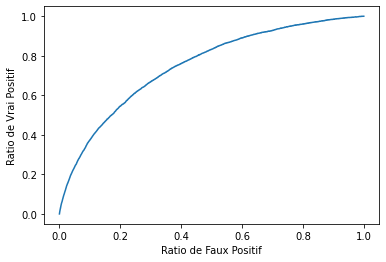

G:\Softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


Training Time: 1.82
Testing Time: 0.03
Accuracy: 0.685
Fbeta: 0.524
[[58217 26697]
 [ 2329  5011]]
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     84914
         1.0       0.16      0.68      0.26      7340

    accuracy                           0.69     92254
   macro avg       0.56      0.68      0.53     92254
weighted avg       0.90      0.69      0.76     92254



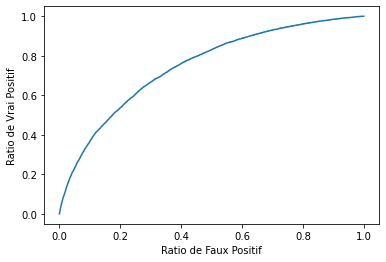

G:\Softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


Training Time: 36.86
Testing Time: 0.03
Accuracy: 0.698
Fbeta: 0.507
[[59608 25306]
 [ 2566  4774]]
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     84914
         1.0       0.16      0.65      0.26      7340

    accuracy                           0.70     92254
   macro avg       0.56      0.68      0.53     92254
weighted avg       0.90      0.70      0.77     92254



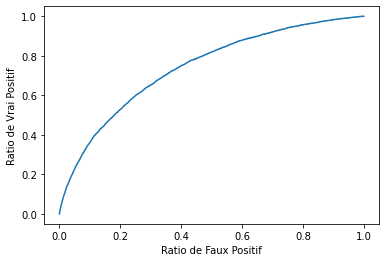

In [12]:
# Regression Logistique
from sklearn.linear_model import LogisticRegression
# Entrainement sur le jeu de données déséquilibré
reg_imb = LogisticRegression(penalty = 'l2', solver = 'liblinear', random_state = 0,
                             max_iter = 1000, n_jobs = -1)
start = time()
reg_imb.fit(X_train, y_train)
end = time()
time_reg_imb_train = end - start
print("Training Time: {:.2f}".format(time_reg_imb_train))
# Prédiction
start = time()
y_reg_imb_pred = reg_imb.predict(X_test)
end = time()
time_reg_imb_pred = end - start
print("Testing Time: {:.2f}".format(time_reg_imb_pred))
# Métriques
acc_reg_imb = metrics.accuracy_score(y_test, y_reg_imb_pred)
print("Accuracy: {:.3f}".format(acc_reg_imb))
fbeta_reg_imb = metrics.fbeta_score(y_test, y_reg_imb_pred, beta=3.16)
print("Fbeta: {:.3f}".format(fbeta_reg_imb))
confusion_reg_imb = metrics.confusion_matrix(y_test, y_reg_imb_pred)
print(confusion_reg_imb)
print(metrics.classification_report(y_test, y_reg_imb_pred))
# Courbe ROC
fpr, tpr, _ = metrics.roc_curve(y_test,  reg_imb.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.ylabel('Ratio de Vrai Positif')
plt.xlabel('Ratio de Faux Positif')
plt.show()

# Entrainement sur le jeu de données sous échantillonné
reg_rus = LogisticRegression(penalty = 'l2', solver = 'liblinear', random_state = 0,
                             max_iter = 1000, n_jobs = -1)
start = time()
reg_rus.fit(X_train_rus, y_train_rus)
end = time()
time_reg_rus_train = end - start
print("Training Time: {:.2f}".format(time_reg_rus_train))
# Prédiction
start = time()
y_reg_rus_pred = reg_rus.predict(X_test)
end = time()
time_reg_rus_pred = end - start
print("Testing Time: {:.2f}".format(time_reg_rus_pred))
# Métriques
acc_reg_rus = metrics.accuracy_score(y_test, y_reg_rus_pred)
print("Accuracy: {:.3f}".format(acc_reg_rus))
fbeta_reg_rus = metrics.fbeta_score(y_test, y_reg_rus_pred, beta=3.16)
print("Fbeta: {:.3f}".format(fbeta_reg_rus))
confusion_reg_rus = metrics.confusion_matrix(y_test, y_reg_rus_pred)
print(confusion_reg_rus)
print(metrics.classification_report(y_test, y_reg_rus_pred))
# Courbe ROC
fpr, tpr, _ = metrics.roc_curve(y_test,  reg_rus.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.ylabel('Ratio de Vrai Positif')
plt.xlabel('Ratio de Faux Positif')
plt.show()

# Entrainement sur le jeu de données sur-échantillonné
reg_smote = LogisticRegression(penalty = 'l2', solver = 'liblinear', random_state = 0,
                               max_iter = 1000, n_jobs = -1)
start = time()
reg_smote.fit(X_train_smote, y_train_smote)
end = time()
time_reg_smote_train = end - start
print("Training Time: {:.2f}".format(time_reg_smote_train))
# Prédiction
start = time()
y_reg_smote_pred = reg_smote.predict(X_test)
end = time()
time_reg_smote_pred = end - start
print("Testing Time: {:.2f}".format(time_reg_smote_pred))
# Métriques
acc_reg_smote = metrics.accuracy_score(y_test, y_reg_smote_pred)
print("Accuracy: {:.3f}".format(acc_reg_smote))
fbeta_reg_smote = metrics.fbeta_score(y_test, y_reg_smote_pred, beta=3.16)
print("Fbeta: {:.3f}".format(fbeta_reg_smote))
confusion_reg_smote = metrics.confusion_matrix(y_test, y_reg_smote_pred)
print(confusion_reg_smote)
print(metrics.classification_report(y_test, y_reg_smote_pred))
# Courbe ROC
fpr, tpr, _ = metrics.roc_curve(y_test,  reg_smote.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.ylabel('Ratio de Vrai Positif')
plt.xlabel('Ratio de Faux Positif')
plt.show()

La comparaison des jeux de données est assez similaire avec celle que nous avons fait lors du kNN, le jeu déséquilibré apporte une précision très élevée mais ne parvient pas à détecter les TP, le jeu sous-échantillonné présente les meilleurs résultats sur la métrique principale (Fbeta score).

Si la regression logistique présente de meilleurs résultats que le kNN, notamment sur une bonne détection des TP, elle échoue en détectant près d'un tiers de faux positifs. Au vu de l'utilisation finale du modèle, ces résultats ne me semblent pas suffisants.

In [13]:
# Random forest avec GridSearch CV
from sklearn.ensemble import GradientBoostingClassifier
# Grilles dans l'ordre de recherche
paramGrid1 = {'loss' : ['deviance', 'exponential'], 'max_depth': [3,4,5],
             'learning_rate':[0.05,0.1,0.02] ,  'n_estimators':[50,100,200], 
             'random_state':[0]}
paramGrid2 = {'loss' : ['exponential'], 'learning_rate':[0.08,0.1,0.12], 'max_depth': [4],
              'n_estimators':[150,200,250], 'random_state':[0]}
paramGrid3 = {'loss' : ['exponential'], 'learning_rate': [0.12, 0.15, 0.25] , 'max_depth': [4],
              'n_estimators':[250,300,400], 'random_state':[0]}

# Entrainement sur le jeu de données sous echantillonné
start = time()
rf_rus = model_selection.GridSearchCV(GradientBoostingClassifier(), paramGrid1, cv=5,
                                      scoring=target)
rf_rus.fit(X_train_rus, y_train_rus)
end = time()
time_rf_grid = end - start
print("Testing Time: {:.2f}".format(time_rf_grid))

print(rf_rus.best_params_)
# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(rf_rus.cv_results_['mean_test_score'], 
                             rf_rus.cv_results_['std_test_score'], rf_rus.cv_results_['params']):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(target,mean,std,params))

Testing Time: 13761.44
{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 200, 'random_state': 0}
Résultats de la validation croisée :
make_scorer(fbeta_score, beta=3.16) = 0.675 (+/-0.008) for {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 50, 'random_state': 0}
make_scorer(fbeta_score, beta=3.16) = 0.684 (+/-0.005) for {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 100, 'random_state': 0}
make_scorer(fbeta_score, beta=3.16) = 0.689 (+/-0.006) for {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 200, 'random_state': 0}
make_scorer(fbeta_score, beta=3.16) = 0.682 (+/-0.007) for {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 50, 'random_state': 0}
make_scorer(fbeta_score, beta=3.16) = 0.690 (+/-0.006) for {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 100, 'random_state': 0}
make_scorer(fbeta_score, beta=3.16) = 0.692 (+/-

En première approche, on a trouvé les meilleurs paramètres tels que : {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 4, 'n_estimators': 200, 'random_state': 0}

En deuxième approche, {'learning_rate': 0.12, 'loss': 'exponential', 'max_depth': 4, 'n_estimators': 250, 'random_state': 0}

En troisième approche, {'learning_rate': 0.12, 'loss': 'exponential', 'max_depth': 4, 'n_estimators': 250, 'random_state': 0} 

Les mêmes paramètres qu'en deuxième approche.

Nous allons maintenant tester ces paramètres avec les 3 jeux de données.

Training Time: 1117.57
Testing Time: 0.83
Accuracy: 0.920
Fbeta: 0.025
[[84751   163]
 [ 7175   165]]
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84914
         1.0       0.50      0.02      0.04      7340

    accuracy                           0.92     92254
   macro avg       0.71      0.51      0.50     92254
weighted avg       0.89      0.92      0.89     92254



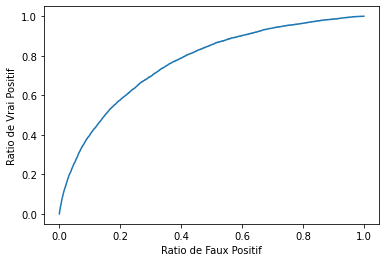

Training Time: 143.84
Testing Time: 0.78
Accuracy: 0.694
Fbeta: 0.534
[[58912 26002]
 [ 2271  5069]]
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.81     84914
         1.0       0.16      0.69      0.26      7340

    accuracy                           0.69     92254
   macro avg       0.56      0.69      0.54     92254
weighted avg       0.90      0.69      0.76     92254



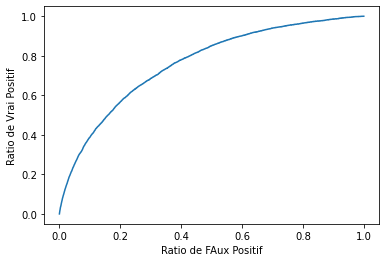

Training Time: 2593.03
Testing Time: 0.86
Accuracy: 0.920
Fbeta: 0.036
[[84647   267]
 [ 7100   240]]
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84914
         1.0       0.47      0.03      0.06      7340

    accuracy                           0.92     92254
   macro avg       0.70      0.51      0.51     92254
weighted avg       0.89      0.92      0.89     92254



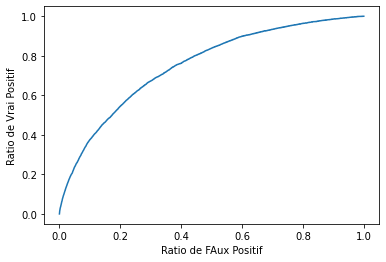

In [14]:
# Random Forest avec Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
# Entrainement sur le jeu de données déséquilibré
rf_imb = GradientBoostingClassifier(learning_rate = 0.12, loss = 'exponential', max_depth = 4, 
                                    n_estimators = 250, random_state = 0)
start = time()
rf_imb.fit(X_train, y_train)
end = time()
time_rf_imb_train = end - start
print("Training Time: {:.2f}".format(time_rf_imb_train))
# Prédiction
start = time()
y_rf_imb_pred = rf_imb.predict(X_test)
end = time()
time_rf_imb_pred = end - start
print("Testing Time: {:.2f}".format(time_rf_imb_pred))
# Métriques
acc_rf_imb = metrics.accuracy_score(y_test, y_rf_imb_pred)
print("Accuracy: {:.3f}".format(acc_rf_imb))
fbeta_rf_imb = metrics.fbeta_score(y_test, y_rf_imb_pred, beta=3.16)
print("Fbeta: {:.3f}".format(fbeta_rf_imb))
confusion_rf_imb = metrics.confusion_matrix(y_test, y_rf_imb_pred)
print(confusion_rf_imb)
print(metrics.classification_report(y_test, y_rf_imb_pred))
# Courbe ROC
fpr, tpr, _ = metrics.roc_curve(y_test,  rf_imb.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.ylabel('Ratio de Vrai Positif')
plt.xlabel('Ratio de Faux Positif')
plt.show()

# Entrainement sur le jeu de données sous échantillonné
rf_rus = GradientBoostingClassifier(learning_rate = 0.12, loss = 'exponential', max_depth = 4, 
                                    n_estimators = 250, random_state = 0)
start = time()
rf_rus.fit(X_train_rus, y_train_rus)
end = time()
time_rf_rus_train = end - start
print("Training Time: {:.2f}".format(time_rf_rus_train))
# Prédiction
start = time()
y_rf_rus_pred = rf_rus.predict(X_test)
end = time()
time_rf_rus_pred = end - start
print("Testing Time: {:.2f}".format(time_rf_rus_pred))
# Métriques
acc_rf_rus = metrics.accuracy_score(y_test, y_rf_rus_pred)
print("Accuracy: {:.3f}".format(acc_rf_rus))
fbeta_rf_rus = metrics.fbeta_score(y_test, y_rf_rus_pred, beta=3.16)
print("Fbeta: {:.3f}".format(fbeta_rf_rus))
confusion_rf_rus = metrics.confusion_matrix(y_test, y_rf_rus_pred)
print(confusion_rf_rus)
print(metrics.classification_report(y_test, y_rf_rus_pred))
# Courbe ROC
fpr, tpr, _ = metrics.roc_curve(y_test,  rf_rus.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.ylabel('Ratio de Vrai Positif')
plt.xlabel('Ratio de FAux Positif')
plt.show()

# Entrainement sur le jeu de données sur-échantillonné
rf_smote = GradientBoostingClassifier(learning_rate = 0.12, loss = 'exponential', max_depth = 4, 
                                    n_estimators = 250, random_state = 0)
start = time()
rf_smote.fit(X_train_smote, y_train_smote)
end = time()
time_rf_smote_train = end - start
print("Training Time: {:.2f}".format(time_rf_smote_train))
# Prédiction
start = time()
y_rf_smote_pred = rf_smote.predict(X_test)
end = time()
time_rf_smote_pred = end - start
print("Testing Time: {:.2f}".format(time_rf_smote_pred))
# Métriques
acc_rf_smote = metrics.accuracy_score(y_test, y_rf_smote_pred)
print("Accuracy: {:.3f}".format(acc_rf_smote))
fbeta_rf_smote = metrics.fbeta_score(y_test, y_rf_smote_pred, beta=3.16)
print("Fbeta: {:.3f}".format(fbeta_rf_smote))
confusion_rf_smote = metrics.confusion_matrix(y_test, y_rf_smote_pred)
print(confusion_rf_smote)
print(metrics.classification_report(y_test, y_rf_smote_pred))
# Courbe ROC
fpr, tpr, _ = metrics.roc_curve(y_test,  rf_smote.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.ylabel('Ratio de Vrai Positif')
plt.xlabel('Ratio de FAux Positif')
plt.show()

Sur le modèle de forêt aléatoire avec boost par gradient, on obtient toujours un meilleur résultat avec la méthode de sous-échantillonnage, malgré la perte d'information que cette dernière induit. Avec un score de 0.534, il est même légèrement supérieur à la méthode de regression logistique, malgré la perte d'information que cette dernière induit.

In [15]:
# Balanced Random Forest avec GridSearch CV
# Dans ce cas, c'est le jeu de données déséquilibré qui est utilisé 
# puisque ce modèle est conçu pour ce cas

from imblearn.ensemble import BalancedRandomForestClassifier
# Grilles dans l'ordre de recherche
paramGrid1 = {'max_depth': [3,4,5], 'n_jobs':[-1] , 'n_estimators':[50,100,200], 
             'random_state':[0]}
paramGrid2 = {'n_jobs':[-1], 'max_depth': [4,5,6],
              'n_estimators':[175,200,225], 'random_state':[0]}
paramGrid3 = {'n_jobs':[-1] , 'max_depth': [6,7,8],
              'n_estimators':[200], 'random_state':[0]}

# Entrainement sur le jeu de données sous echantillonné
start = time()
rfb_imb = model_selection.GridSearchCV(BalancedRandomForestClassifier(), paramGrid1, cv=5,
                                      scoring=target)
rfb_imb.fit(X_train, y_train)
end = time()
time_rfb_grid = end - start
print("Testing Time: {:.2f}".format(time_rfb_grid))

print(rfb_imb.best_params_)
# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(rfb_imb.cv_results_['mean_test_score'], 
                             rfb_imb.cv_results_['std_test_score'], rfb_imb.cv_results_['params']):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(target,mean,std,params))

Testing Time: 141.81
{'max_depth': 5, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 0}
Résultats de la validation croisée :
make_scorer(fbeta_score, beta=3.16) = 0.498 (+/-0.005) for {'max_depth': 3, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 0}
make_scorer(fbeta_score, beta=3.16) = 0.502 (+/-0.004) for {'max_depth': 3, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 0}
make_scorer(fbeta_score, beta=3.16) = 0.502 (+/-0.004) for {'max_depth': 3, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 0}
make_scorer(fbeta_score, beta=3.16) = 0.498 (+/-0.005) for {'max_depth': 4, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 0}
make_scorer(fbeta_score, beta=3.16) = 0.503 (+/-0.005) for {'max_depth': 4, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 0}
make_scorer(fbeta_score, beta=3.16) = 0.505 (+/-0.006) for {'max_depth': 4, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 0}
make_scorer(fbeta_score, beta=3.16) = 0.507 (+/-0.004) for {'max_depth': 5, 'n_estimators': 5

En première approche, on obtient les meilleurs paramètres suivants : {'max_depth': 5, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 0}

En deuxième approche, {'max_depth': 6, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 0}

En troisième approche, {'max_depth': 8, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 0}

Nous allons maintenant tester ces paramètres avec les 3 jeux de données.

Training Time: 7.82
Testing Time: 0.48
Accuracy: 0.669
Fbeta: 0.511
[[56767 28147]
 [ 2393  4947]]
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79     84914
         1.0       0.15      0.67      0.24      7340

    accuracy                           0.67     92254
   macro avg       0.55      0.67      0.52     92254
weighted avg       0.90      0.67      0.74     92254



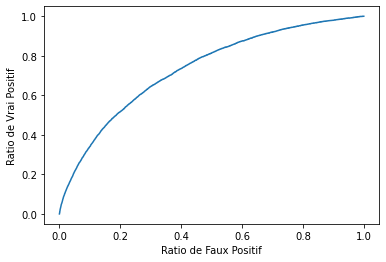

Training Time: 3.36
Testing Time: 0.44
Accuracy: 0.668
Fbeta: 0.517
[[56624 28290]
 [ 2328  5012]]
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79     84914
         1.0       0.15      0.68      0.25      7340

    accuracy                           0.67     92254
   macro avg       0.56      0.67      0.52     92254
weighted avg       0.90      0.67      0.74     92254



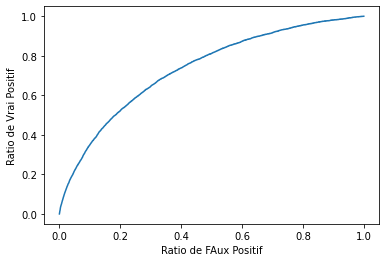

Training Time: 77.83
Testing Time: 0.79
Accuracy: 0.864
Fbeta: 0.191
[[78331  6583]
 [ 5925  1415]]
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.93     84914
         1.0       0.18      0.19      0.18      7340

    accuracy                           0.86     92254
   macro avg       0.55      0.56      0.56     92254
weighted avg       0.87      0.86      0.87     92254



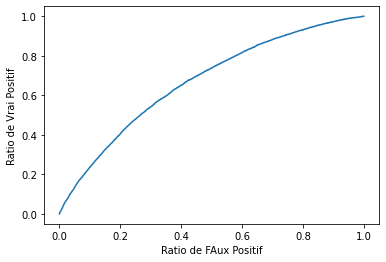

In [16]:
# Balanced Random Forest avec Gradient Boosting
from imblearn.ensemble import BalancedRandomForestClassifier
# Entrainement sur le jeu de données déséquilibré
rfb_imb = BalancedRandomForestClassifier(max_depth = 8, n_estimators = 200, n_jobs = -1,
                                         random_state = 0)
start = time()
rfb_imb.fit(X_train, y_train)
end = time()
time_rfb_imb_train = end - start
print("Training Time: {:.2f}".format(time_rfb_imb_train))
# Prédiction
start = time()
y_rfb_imb_pred = rfb_imb.predict(X_test)
end = time()
time_rfb_imb_pred = end - start
print("Testing Time: {:.2f}".format(time_rfb_imb_pred))
# Métriques
acc_rfb_imb = metrics.accuracy_score(y_test, y_rfb_imb_pred)
print("Accuracy: {:.3f}".format(acc_rfb_imb))
fbeta_rfb_imb = metrics.fbeta_score(y_test, y_rfb_imb_pred, beta=3.16)
print("Fbeta: {:.3f}".format(fbeta_rfb_imb))
confusion_rfb_imb = metrics.confusion_matrix(y_test, y_rfb_imb_pred)
print(confusion_rfb_imb)
print(metrics.classification_report(y_test, y_rfb_imb_pred))
# Courbe ROC
fpr, tpr, _ = metrics.roc_curve(y_test,  rfb_imb.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.ylabel('Ratio de Vrai Positif')
plt.xlabel('Ratio de Faux Positif')
plt.show()

# Entrainement sur le jeu de données sous échantillonné
rfb_rus = BalancedRandomForestClassifier(max_depth = 8, n_estimators = 200, n_jobs = -1,
                                         random_state = 0)
start = time()
rfb_rus.fit(X_train_rus, y_train_rus)
end = time()
time_rfb_rus_train = end - start
print("Training Time: {:.2f}".format(time_rfb_rus_train))
# Prédiction
start = time()
y_rfb_rus_pred = rfb_rus.predict(X_test)
end = time()
time_rfb_rus_pred = end - start
print("Testing Time: {:.2f}".format(time_rfb_rus_pred))
# Métriques
acc_rfb_rus = metrics.accuracy_score(y_test, y_rfb_rus_pred)
print("Accuracy: {:.3f}".format(acc_rfb_rus))
fbeta_rfb_rus = metrics.fbeta_score(y_test, y_rfb_rus_pred, beta=3.16)
print("Fbeta: {:.3f}".format(fbeta_rfb_rus))
confusion_rfb_rus = metrics.confusion_matrix(y_test, y_rfb_rus_pred)
print(confusion_rfb_rus)
print(metrics.classification_report(y_test, y_rfb_rus_pred))
# Courbe ROC
fpr, tpr, _ = metrics.roc_curve(y_test,  rfb_rus.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.ylabel('Ratio de Vrai Positif')
plt.xlabel('Ratio de FAux Positif')
plt.show()

# Entrainement sur le jeu de données sur-échantillonné
rfb_smote = BalancedRandomForestClassifier(max_depth = 8, n_estimators = 200, n_jobs = -1,
                                         random_state = 0)
start = time()
rfb_smote.fit(X_train_smote, y_train_smote)
end = time()
time_rfb_smote_train = end - start
print("Training Time: {:.2f}".format(time_rfb_smote_train))
# Prédiction
start = time()
y_rfb_smote_pred = rfb_smote.predict(X_test)
end = time()
time_rfb_smote_pred = end - start
print("Testing Time: {:.2f}".format(time_rfb_smote_pred))
# Métriques
acc_rfb_smote = metrics.accuracy_score(y_test, y_rfb_smote_pred)
print("Accuracy: {:.3f}".format(acc_rfb_smote))
fbeta_rfb_smote = metrics.fbeta_score(y_test, y_rfb_smote_pred, beta=3.16)
print("Fbeta: {:.3f}".format(fbeta_rfb_smote))
confusion_rfb_smote = metrics.confusion_matrix(y_test, y_rfb_smote_pred)
print(confusion_rfb_smote)
print(metrics.classification_report(y_test, y_rfb_smote_pred))
# Courbe ROC
fpr, tpr, _ = metrics.roc_curve(y_test,  rfb_smote.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.ylabel('Ratio de Vrai Positif')
plt.xlabel('Ratio de FAux Positif')
plt.show()

# Synthèse
Aucune courbe ROC ne montre un coude marqué suggerant une possible optimisation du seuil de détection. De plus, ces courbes étant calculées sur le jeu de données de test, il ne faut pas oublier que toute optimisation se fera donc à posteriori du test, ce qui crée un biais et risque de provoquer de l'overfitting.

En se basant sur le Fbeta score et sur les détails de la classification, le modèle optimal semble être la forêt aléatoire avec boosting par gradient sur le jeu de données sous-échantillonné. Si l'on se réfère à la matrice de confusion, on a 27% de FP ce qui est un point négatif non négligeable mais on réussi à repérer 69% de TP ce qui est plutôt élevé considérant que ce n'est pas un problème de classification aisé (cf Visualisation tsne).

Enfin, il faut tenir compte d'une information non négligeable : les observations de ce jeu de données font partie d'un panel de personnes ayant contracté un prêt, ce qui signifie qu'une méthode (humaine ou machine) a été utilisée pour les sélectionner, notre algorithme passe donc après qu'un premier tri ait déjà été fait.

G:\Softwares\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


Training Time: 662.12
Testing Time: 0.06
Accuracy: 0.688
Fbeta: 0.523
[[58497 26417]
 [ 2360  4980]]
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     84914
         1.0       0.16      0.68      0.26      7340

    accuracy                           0.69     92254
   macro avg       0.56      0.68      0.53     92254
weighted avg       0.90      0.69      0.76     92254



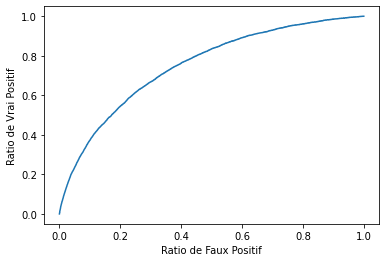

In [17]:
# Test de la fonction class_weight, cette fonction n'existe pas pour GradientBoostingClassifier,
# notre modèle optimal, mais on peut la tester sur LogisticRegression

# Regression Logistique
from sklearn.linear_model import LogisticRegression
# Entrainement sur le jeu de données déséquilibré
regCW_imb = LogisticRegression(penalty = 'l2', solver = 'liblinear', random_state = 0,
                             max_iter = 1000, class_weight='balanced', n_jobs = -1)
start = time()
regCW_imb.fit(X_train, y_train)
end = time()
time_regCW_imb_train = end - start
print("Training Time: {:.2f}".format(time_regCW_imb_train))
# Prédiction
start = time()
y_regCW_imb_pred = regCW_imb.predict(X_test)
end = time()
time_regCW_imb_pred = end - start
print("Testing Time: {:.2f}".format(time_regCW_imb_pred))
# Métriques
acc_regCW_imb = metrics.accuracy_score(y_test, y_regCW_imb_pred)
print("Accuracy: {:.3f}".format(acc_regCW_imb))
fbeta_regCW_imb = metrics.fbeta_score(y_test, y_regCW_imb_pred, beta=3.16)
print("Fbeta: {:.3f}".format(fbeta_regCW_imb))
confusion_regCW_imb = metrics.confusion_matrix(y_test, y_regCW_imb_pred)
print(confusion_regCW_imb)
print(metrics.classification_report(y_test, y_regCW_imb_pred))
# Courbe ROC
fpr, tpr, _ = metrics.roc_curve(y_test,  regCW_imb.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.ylabel('Ratio de Vrai Positif')
plt.xlabel('Ratio de Faux Positif')
plt.show()


En utilisant class_weight='balanced' sur le jeu de données déséquilibrées, on obtient un résultat de fbeta_score bien plus élevé, il s'avère donc que ce ne sont pas deux méthodes redondantes. Ici on obtient des résultats très très proches du même modèle sans class_weight sur les données sous-échantillonnées.

        Dataset  Accuracy     Fbeta  TimeTrain     TimeTest
0   Imabalanced  0.914974  0.017805   0.068028   525.712384
1  Undersampled  0.550545  0.410665   0.015000    75.264565
2         Smote  0.630975  0.344625   0.139999  1048.881881


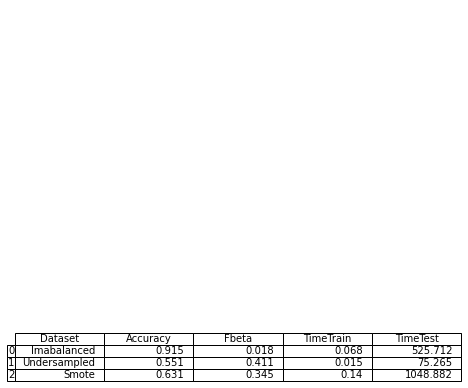

In [18]:
#Tableau des résultats des modèles optimisés Knn
from pandas.plotting import table
synthese_knn = pd.DataFrame()
synthese_knn = synthese_knn.assign(Dataset = ['Imabalanced', 'Undersampled','Smote'])
synthese_knn = synthese_knn.assign(Accuracy = [acc_knn_imb,acc_knn_rus,acc_knn_smote])
synthese_knn = synthese_knn.assign(Fbeta = [fbeta_knn_imb,fbeta_knn_rus,fbeta_knn_smote])
synthese_knn = synthese_knn.assign(TimeTrain = [time_knn_imb_train,time_knn_rus_train,
                                                time_knn_smote_train])
synthese_knn = synthese_knn.assign(TimeTest = [time_knn_imb_pred,time_knn_rus_pred,time_knn_smote_pred])
print(synthese_knn)

# Affichage sous forme de tableau à télécharger
plt.figure(figsize=(8,6))
# Pas d'axes
ax = plt.subplot(frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#Création du tableau
table(ax, synthese_knn.round(decimals=3))
plt.show()

         Dataset  Accuracy     Fbeta   TimeTrain  TimeTest
0    Imabalanced  0.920296  0.011664   13.402086  0.029001
1   Undersampled  0.685369  0.524263    1.822999  0.030002
2          Smote  0.697878  0.507334   36.856027  0.028975
3  Imbalanced CW  0.688068  0.522568  662.124608  0.060018


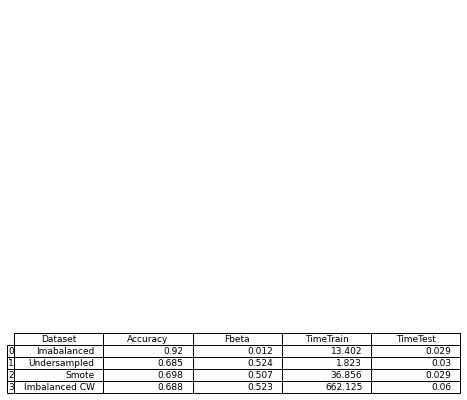

In [29]:
#Tableau des résultats des modèles optimisés Regression Logistique
synthese_reg = pd.DataFrame()
synthese_reg = synthese_reg.assign(Dataset = ['Imabalanced', 'Undersampled','Smote','Imbalanced CW'])
synthese_reg = synthese_reg.assign(Accuracy = [acc_reg_imb,acc_reg_rus,acc_reg_smote, acc_regCW_imb])
synthese_reg = synthese_reg.assign(Fbeta = [fbeta_reg_imb,fbeta_reg_rus,fbeta_reg_smote,
                                            fbeta_regCW_imb])
synthese_reg = synthese_reg.assign(TimeTrain = [time_reg_imb_train,time_reg_rus_train, 
                                                time_reg_smote_train, time_regCW_imb_train])
synthese_reg = synthese_reg.assign(TimeTest = [time_reg_imb_pred,time_reg_rus_pred,time_reg_smote_pred,
                                               time_regCW_imb_pred])
print(synthese_reg)

# Affichage sous forme de tableau à télécharger
plt.figure(figsize=(8,6))
# Pas d'axes
ax = plt.subplot(frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#Création du tableau
table(ax, synthese_reg.round(decimals=3))
plt.show()

        Dataset  Accuracy     Fbeta    TimeTrain  TimeTest
0   Imabalanced  0.920459  0.024621  1117.565629  0.827999
1  Undersampled  0.693531  0.533568   143.835088  0.776999
2         Smote  0.920144  0.035725  2593.034622  0.862001


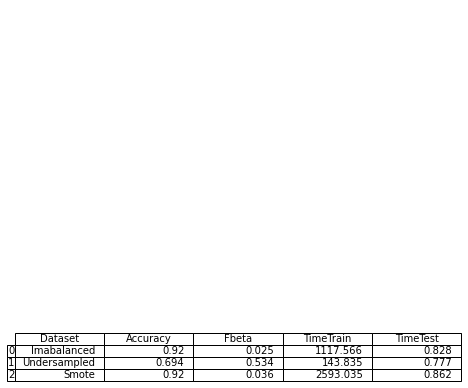

In [25]:
#Tableau des résultats des modèles optimisés Random Forest
synthese_rf = pd.DataFrame()
synthese_rf = synthese_rf.assign(Dataset = ['Imabalanced', 'Undersampled','Smote'])
synthese_rf = synthese_rf.assign(Accuracy = [acc_rf_imb,acc_rf_rus,acc_rf_smote])
synthese_rf = synthese_rf.assign(Fbeta = [fbeta_rf_imb,fbeta_rf_rus,fbeta_rf_smote])
synthese_rf = synthese_rf.assign(TimeTrain = [time_rf_imb_train,time_rf_rus_train,time_rf_smote_train])
synthese_rf = synthese_rf.assign(TimeTest = [time_rf_imb_pred,time_rf_rus_pred,time_rf_smote_pred])
print(synthese_rf)

# Affichage sous forme de tableau à télécharger
plt.figure(figsize=(8,6))
# Pas d'axes
ax = plt.subplot(frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#Création du tableau
table(ax, synthese_rf.round(decimals=3))
plt.show()

        Dataset  Accuracy     Fbeta  TimeTrain  TimeTest
0   Imabalanced  0.668957  0.510825   7.819163  0.475000
1  Undersampled  0.668112  0.516527   3.361999  0.440001
2         Smote  0.864418  0.191219  77.826642  0.792004


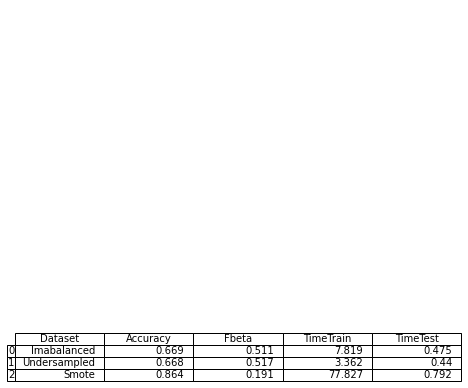

In [26]:
#Tableau des résultats des modèles optimisés Balanced Random Forest
synthese_rfb = pd.DataFrame()
synthese_rfb = synthese_rfb.assign(Dataset = ['Imabalanced', 'Undersampled','Smote'])
synthese_rfb = synthese_rfb.assign(Accuracy = [acc_rfb_imb,acc_rfb_rus,acc_rfb_smote])
synthese_rfb = synthese_rfb.assign(Fbeta = [fbeta_rfb_imb,fbeta_rfb_rus,fbeta_rfb_smote])
synthese_rfb = synthese_rfb.assign(TimeTrain = [time_rfb_imb_train,time_rfb_rus_train,time_rfb_smote_train])
synthese_rfb = synthese_rfb.assign(TimeTest = [time_rfb_imb_pred,time_rfb_rus_pred,time_rfb_smote_pred])
print(synthese_rfb)

# Affichage sous forme de tableau à télécharger
plt.figure(figsize=(8,6))
# Pas d'axes
ax = plt.subplot(frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#Création du tableau
table(ax, synthese_rfb.round(decimals=3))
plt.show()

In [11]:
# Persistance du modèle
import joblib
joblib.dump(rf_rus, 'model_rf.pkl')

NameError: name 'rf_rus' is not defined

In [149]:
# Création d'un échantillon de données réduit pour le cloud
# Pour la prédiction (normalisé)
# On réintègre le SK_ID_CURR
data_sampled = data.join(SK_ID_CURR)
data_sampled = data_sampled.sample(frac=0.09, random_state=0)
data_sampled.to_csv(os.path.join(output_dir,'data_sampled.csv'), index=False)
# Pour l'affichage de graphiques
data_chart = pd.read_csv(os.path.join(default_dir,'data_train.csv'))
data_chart_sampled = data_chart.sample(frac=0.09, random_state=0)
data_chart_sampled.to_csv(os.path.join(output_dir,'data_chart_sampled.csv'), index=False)

In [152]:
# Test de l'API de prédiction
profile_ID = str(149741)
query_str = str('SK_ID_CURR == '+ profile_ID)
profile_data = data_sampled.query(query_str)
profile_data = profile_data.drop(['SK_ID_CURR','TARGET'], axis = 1)
profile_data = profile_data.to_dict(orient='list')
import json
request = json.dumps(profile_data)
URL='http://travelasateam.pythonanywhere.com/predict/'
import requests
headers = {'Content-Type': 'application/json'}
r = requests.post(URL, headers=headers, data = request, verify=False)
print(r.json())

[1.0]


In [110]:
profile_ID = str(363290)
query_str = str('SK_ID_CURR == '+ profile_ID)
profile_data = data.query(query_str)
profile_data.index

Int64Index([227307], dtype='int64')

In [154]:
len(profile_data)

243

In [155]:
profile_ID = str(363290)
query_str = str('SK_ID_CURR == '+ profile_ID)
profile_data = data_sampled.query(query_str)
profile_index = profile_data.index[0]
profile_data = profile_data.drop(['SK_ID_CURR','TARGET'], axis = 1)
profile_data = profile_data.to_dict(orient='list')
request = json.dumps(profile_data)
        
URL='http://travelasateam.pythonanywhere.com/predict/'
headers = {'Content-Type': 'application/json'}
        
r = requests.post(URL, headers=headers, data = request, verify=False)
if r.json()[0]>0.5 :
    print('y')
else :
    print('n')

n


In [112]:
data.shape

(307511, 245)

In [150]:
data_sampled.shape

(27676, 245)

In [116]:
data_sampled = data_sampled.reset_index()

In [119]:
profile_ID = str(149741)
query_str = str('SK_ID_CURR == '+ profile_ID)
profile_data = data_sampled.query(query_str)
profile_data.index

Int64Index([0], dtype='int64')

In [142]:
data_sampled.shape

(27676, 245)

In [143]:
data.shape

(307511, 244)

In [146]:
data_sampled.shape

(27676, 245)

In [151]:
data_sampled['TARGET'].head()

42962     1.0
227307    0.0
290035    0.0
239833    0.0
76427     0.0
Name: TARGET, dtype: float64

In [158]:
data_sampled.shape

(27676, 246)

In [157]:
data_sampled.reset_index(inplace=True)

In [159]:
data_sampled.head()

,index,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYP

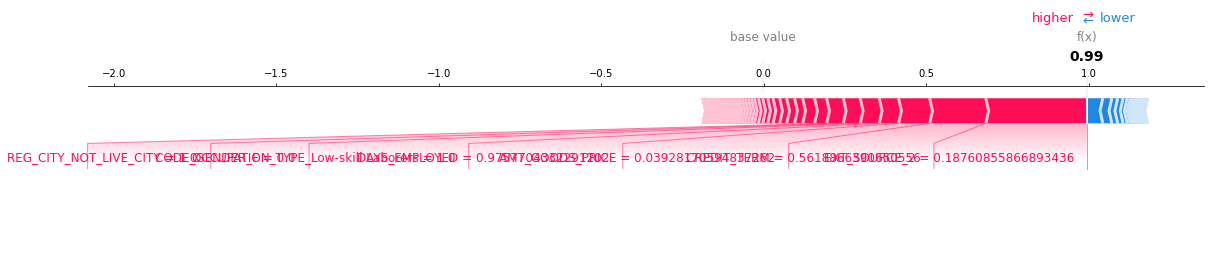

In [85]:
import shap
model = joblib.load('model_rf.pkl')
explainer = shap.TreeExplainer(model)

data_SHAP = data_sampled.drop(['SK_ID_CURR','TARGET'], axis = 1)
data_SHAP.head()
shap_values = explainer.shap_values(data_SHAP.values)
shap.force_plot(explainer.expected_value, 
    shap_values[-1:], features=data_SHAP.values[-1:], 
    feature_names=data_SHAP.columns,
    matplotlib=True, show=False, plot_cmap=['#77dd77', '#f99191'])
plt.show()

In [98]:

URL='http://travelasateam.pythonanywhere.com/model/'
import requests

r = requests.get(URL, verify=False)
print(r)

<Response [500]>


In [96]:
import jsonify

ModuleNotFoundError: No module named 'jsonify'

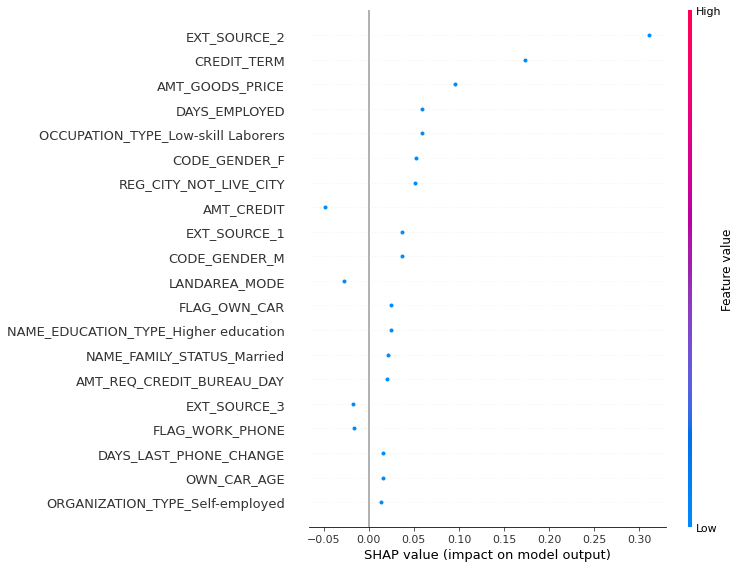

In [70]:
shap.summary_plot(shap_values[-1:], data_SHAP.values[-1:], feature_names=data_SHAP.columns, max_display=20)
#shap.bar_plot(shap_values=shap_values, feature_names=data_SHAP.columns, max_display=10)
plt.show()

In [71]:
shap.plots.bar(shap_values[0])


AssertionError: You must pass an Explanation object, Cohorts object, or dictionary to bar plot!

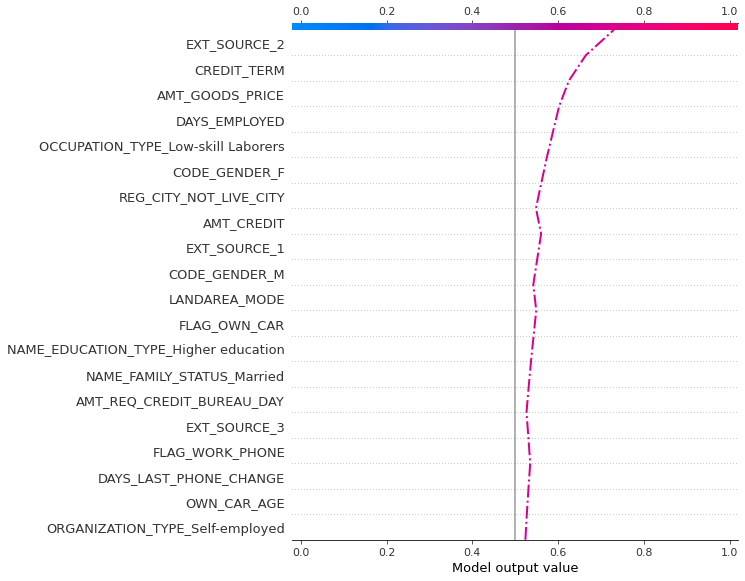

In [55]:
shap.decision_plot(explainer.expected_value[-1:], shap_values[-1:], data_SHAP.columns,
                   link='logit', highlight=0)





100%|===================| 27665/27676 [01:15<00:00]        

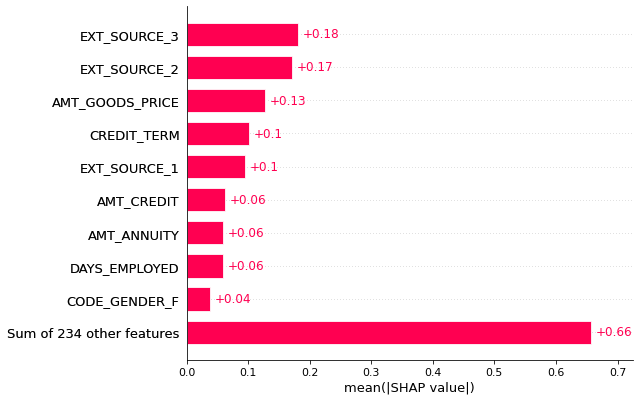

In [121]:
explainer = shap.Explainer(model, data_SHAP)
shap_values = explainer(data_SHAP, check_additivity=False)
shap.plots.bar(shap_values)

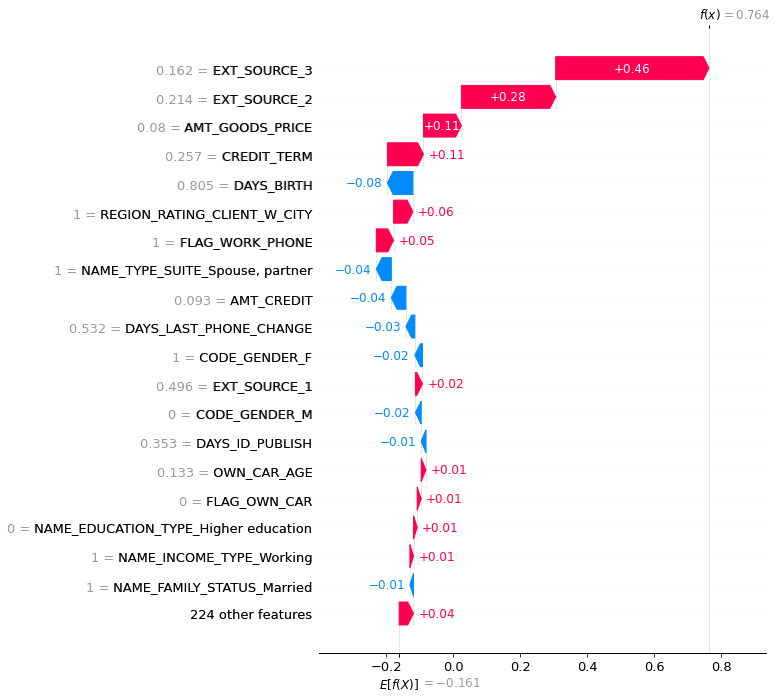

In [133]:
shap.plots.waterfall(shap_values[profile_data.index[0]], max_display=20)

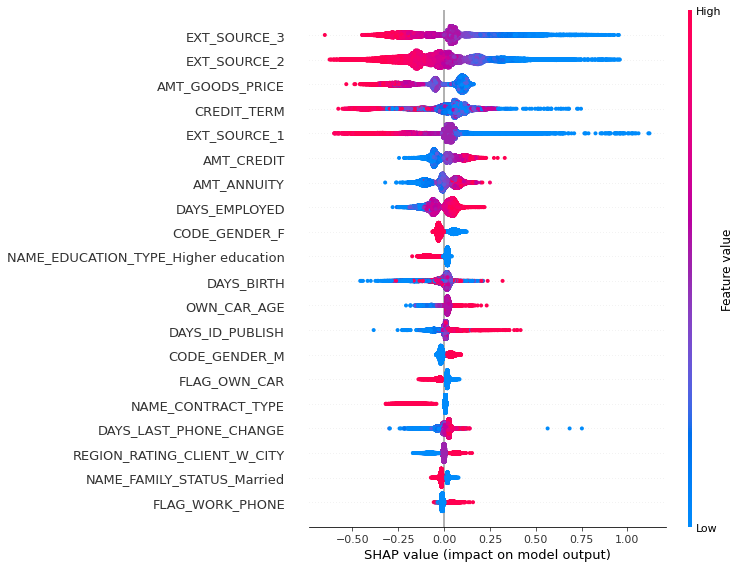

In [132]:
shap.summary_plot(shap_values, data_SHAP.values, feature_names=data_SHAP.columns,
                  max_display=20)

In [128]:
profile_data.index[0]

0

In [134]:
data_sampled.head()

,level_0,index,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZA

In [103]:
shap_values[0]

.values =
array([ 5.87126144e-03,  1.19157312e-02,  1.63863514e-03,  2.20487852e-03,
       -4.12745085e-03, -4.37438746e-02,  4.24079854e-03,  1.13330193e-01,
        6.49911554e-03, -7.60632587e-02,  5.55203243e-03,  6.20389545e-03,
       -1.45409824e-02,  1.43541757e-02,  0.00000000e+00,  0.00000000e+00,
        5.14170618e-02,  0.00000000e+00, -9.26082933e-03,  4.34485392e-04,
       -3.07793465e-03,  2.31770920e-03,  5.77862070e-02,  9.45311868e-03,
        0.00000000e+00,  8.25441489e-04,  3.39320749e-04, -3.64181317e-03,
        3.85581572e-04,  2.31641913e-04,  2.10255436e-02,  2.81591442e-01,
        4.57860103e-01, -4.23574603e-03, -5.22297621e-04,  3.91895030e-03,
        1.04031143e-03,  8.87632146e-04,  3.46911475e-04, -7.25312624e-04,
        5.53140524e-04,  2.59912582e-04,  8.18462931e-04, -6.59081428e-04,
        1.01797038e-02,  4.91794534e-04,  3.20745092e-04,  1.53252657e-03,
       -3.37968211e-03,  6.70352228e-03,  1.25468212e-03,  5.23641034e-03,
        0.00000

In [104]:
shap_values.head()

AttributeError: 'Explanation' object has no attribute 'head'

In [43]:
shap_values.shape

(27676, 243)

In [44]:
data_SHAP.columns.shape

(243,)

In [24]:
data_SHAP = data_sampled.drop(['SK_ID_CURR','TARGET'], axis = 1)
data_SHAP.head()
shap_values = explainer.shap_values(data_SHAP.values)
shap_plot = shap.force_plot(explainer.expected_value, 
    shap_values[-1:], features=data_SHAP.values.iloc[-1:], 
    feature_names=data_SHAP.columns,
    matplotlib=True, show=False, plot_cmap=['#77dd77', '#f99191'])
plt.show()

NameError: name 'explainer' is not defined

In [21]:
data_sampled['TARGET']

42962     1.0
227307    0.0
290035    0.0
239833    0.0
76427     0.0
305881    0.0
222747    0.0
34699     0.0
116270    0.0
146605    0.0
289652    0.0
172432    0.0
247580    0.0
146578    0.0
156117    0.0
119071    0.0
176090    0.0
271712    0.0
100942    0.0
238476    0.0
5087      0.0
35711     0.0
180885    0.0
122792    1.0
295281    0.0
257577    0.0
86550     0.0
26445     0.0
252359    0.0
163926    0.0
210425    0.0
22762     0.0
3563      0.0
226695    0.0
93492     1.0
106202    0.0
13250     0.0
50036     0.0
117145    0.0
280226    0.0
138066    0.0
893       0.0
94466     0.0
200931    0.0
60918     0.0
42111     0.0
191474    0.0
267616    0.0
259567    0.0
175452    0.0
178088    0.0
214980    0.0
152245    0.0
267668    0.0
43229     1.0
306084    0.0
64161     1.0
139362    0.0
214738    0.0
207198    1.0
250231    0.0
53997     0.0
202463    0.0
176536    0.0
181654    0.0
179547    0.0
139377    0.0
191667    0.0
14703     0.0
227940    0.0
214770    0.0
211881